# Pensiones
En este cuaderno reproducimos el flujo de trabajo (pipeline) completo de `pensiones.py`. Cada bloque incluye una breve descripción, el código correspondiente y una nota rápida con los hallazgos visibles tras la ejecución.

## 1. Configuración e importaciones
Definimos las librerías, rutas y constantes necesarias para conectarnos al portal de datos abiertos.

In [69]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns

from scipy.stats import entropy as shannon_entropy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

BASE = "https://www.datos.gov.co"
RESOURCE = "uawh-cjvi"
URL = f"{BASE}/resource/{RESOURCE}.json"
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("data/graficas_comparativas").mkdir(parents=True, exist_ok=True)
Path("data/graficas_modelado").mkdir(parents=True, exist_ok=True)


La configuración prepara todas las dependencias utilizadas en `pensiones.py` y asegura la existencia de las carpetas donde se guardan los artefactos.

## 2. Descarga incremental del dataset
Consultamos la API Socrata en bloques de 50.000 filas y concatenamos el resultado en un DataFrame único.

In [70]:
try:
    total_filas = int(requests.get(f"{URL}?$select=count(*)").json()[0]["count"])
except Exception:
    total_filas = None
print("Total reportado:", total_filas)

lista_paginas = []
limit = 50000
offset = 0
while True:
    params = {"$limit": limit, "$offset": offset}
    respuesta = requests.get(URL, params=params, timeout=120)
    respuesta.raise_for_status()
    datos = respuesta.json()
    if not datos:
        break
    lista_paginas.append(pd.DataFrame(datos))
    offset += limit
    print(f"Descargadas: {offset} filas…")
    time.sleep(0.3)

df = pd.concat(lista_paginas, ignore_index=True) if lista_paginas else pd.DataFrame()
print(df.shape)
print(df.head())

Total reportado: 90219
Descargadas: 50000 filas…
Descargadas: 100000 filas…
(90219, 6)
                     fecha codigo_entidad nombre_entidad codigo_patrimonio  \
0  2016-01-01T00:00:00.000              2   "Proteccion"                 1   
1  2016-01-01T00:00:00.000              2   "Proteccion"                 2   
2  2016-01-01T00:00:00.000              2   "Proteccion"              1000   
3  2016-01-01T00:00:00.000              2   "Proteccion"              5000   
4  2016-01-01T00:00:00.000              2   "Proteccion"              6000   

                      nombre_fondo  valor_unidad  
0   Fondo de Cesantias Largo Plazo  23375.960000  
1   Fondo de Cesantias Corto Plazo  23322.600000  
2      Fondo de Pensiones Moderado  37972.060000  
3   Fondo de Pensiones Conservador  39207.350000  
4  Fondo de Pensiones Mayor Riesgo  38410.190000  


Tras la descarga se espera ver el total de registros reportado por la API y los avances por bloque; el tamaño final confirma que no quedaron páginas pendientes.

## 3. Conversión de tipos y limpieza básica
Normalizamos la columna fecha y limpiamos `valor_unidad` para eliminar caracteres residuales.

In [71]:
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["valor_unidad"] = (
    df["valor_unidad"].astype(str)
    .str.replace(r"[^\d\-,\.]", "", regex=True)
    .str.replace(",", ".", regex=False)
    .astype(float)
)
df['valor_unidad'] = df['valor_unidad'].ffill().interpolate()
print(df.dtypes)


fecha                datetime64[ns]
codigo_entidad               object
nombre_entidad               object
codigo_patrimonio            object
nombre_fondo                 object
valor_unidad                float64
dtype: object


En esta etapa las columnas clave aparecen ya como `datetime64` y `float`; los valores faltantes en `valor_unidad` quedan rellenados para evitar saltos en los cálculos posteriores.

## 4. Inspección de nulos y cardinalidades
Medimos porcentajes de nulos, cardinalidad y distribuciones básicas de entidades y fondos.

In [72]:
nulls = df.isna().mean().sort_values(ascending=False).mul(100).round(2)
print(nulls)
cardinalidad = df.nunique(dropna=True).sort_values(ascending=False)
print(cardinalidad)
print("Valores únicos en nombre_entidad:", df["nombre_entidad"].dropna().unique()[:10])
print("Valores únicos en nombre_fondo:", df["nombre_fondo"].dropna().unique()[:10])
print(df["nombre_entidad"].value_counts(dropna=False).head(10))
print(df["nombre_fondo"].value_counts(dropna=False).head(20))


fecha                0.0
codigo_entidad       0.0
nombre_entidad       0.0
codigo_patrimonio    0.0
nombre_fondo         0.0
valor_unidad         0.0
dtype: float64
valor_unidad         89421
fecha                 3609
codigo_patrimonio        7
nombre_fondo             7
codigo_entidad           4
nombre_entidad           4
dtype: int64
Valores únicos en nombre_entidad: ['"Proteccion"' '"Porvenir"' 'Skandia Afp - Accai S.A.'
 '"Colfondos S.A." Y "Colfondos"']
Valores únicos en nombre_fondo: ['Fondo de Cesantias Largo Plazo' 'Fondo de Cesantias Corto Plazo'
 'Fondo de Pensiones Moderado' 'Fondo de Pensiones Conservador'
 'Fondo de Pensiones Mayor Riesgo' 'Fondo de Pensiones Retiro Programado'
 'Fondo de Pensiones Alternativo']
nombre_entidad
Skandia Afp - Accai S.A.          25263
"Porvenir"                        21654
"Colfondos S.A." Y "Colfondos"    21654
"Proteccion"                      21648
Name: count, dtype: int64
nombre_fondo
Fondo de Cesantias Largo Plazo          14435
Fon

Aquí suele observarse que los campos críticos tienen muy pocos nulos y que la mayor concentración de registros se da en las cuatro AFP principales.

## 5. Tablas de referencia y relaciones de claves
Guardamos los diccionarios entidad/código, fondo/patrimonio y verificamos si las llaves son uno a uno.

In [73]:
df_clean = df.drop(columns=["codigo_entidad", "codigo_patrimonio"])
df_clean.to_csv("data/raw/pensionesLimpio.csv", index=False)

df[["nombre_entidad", "codigo_entidad"]].drop_duplicates().to_csv("data/raw/entidad_codigo.csv", index=False)
df[["nombre_fondo", "codigo_patrimonio"]].drop_duplicates().to_csv("data/raw/fondos_codigo.csv", index=False)

print(df.groupby("codigo_entidad")["nombre_entidad"].nunique().sort_values(ascending=False).head())
print(df.groupby("codigo_patrimonio")["nombre_fondo"].nunique().sort_values(ascending=False).head())
print(df.groupby("nombre_entidad")["codigo_entidad"].nunique().sort_values(ascending=False).head())
print(df.groupby("nombre_fondo")["codigo_patrimonio"].nunique().sort_values(ascending=False).head())


codigo_entidad
10    1
2     1
3     1
9     1
Name: nombre_entidad, dtype: int64
codigo_patrimonio
1       1
1000    1
2       1
5000    1
6000    1
Name: nombre_fondo, dtype: int64
nombre_entidad
"Colfondos S.A." Y "Colfondos"    1
"Porvenir"                        1
"Proteccion"                      1
Skandia Afp - Accai S.A.          1
Name: codigo_entidad, dtype: int64
nombre_fondo
Fondo de Cesantias Corto Plazo     1
Fondo de Cesantias Largo Plazo     1
Fondo de Pensiones Alternativo     1
Fondo de Pensiones Conservador     1
Fondo de Pensiones Mayor Riesgo    1
Name: codigo_patrimonio, dtype: int64


El resultado confirma que la codificación es casi uno-a-uno, lo que habilita cruces confiables con otras fuentes.

## 6. Normalización de textos y análisis de duplicados/outliers
Limpiamos espacios repetidos, removemos duplicados y evaluamos límites tipo IQR para marcar outliers.

In [74]:
for c in ["nombre_entidad", "nombre_fondo"]:
    df[c] = df[c].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

print(df[["nombre_entidad", "nombre_fondo"]].nunique())

duplicados = df.duplicated().sum()
print("Duplicados exactos:", duplicados)
if duplicados:
    df = df.drop_duplicates()

duplicados_conceptuales = df.duplicated(subset=['nombre_entidad', 'nombre_fondo', 'fecha']).sum()
print("Duplicados entidad-fondo-fecha:", duplicados_conceptuales)
if duplicados_conceptuales:
    df = df.drop_duplicates(subset=['nombre_entidad', 'nombre_fondo', 'fecha'], keep='first')

Q1 = df['valor_unidad'].quantile(0.25)
Q3 = df['valor_unidad'].quantile(0.75)
IQR = Q3 - Q1
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR
outliers = df[(df['valor_unidad'] < limite_inferior) | (df['valor_unidad'] > limite_superior)]
df['es_outlier'] = ((df['valor_unidad'] < limite_inferior) | (df['valor_unidad'] > limite_superior))
print(len(outliers))


nombre_entidad    4
nombre_fondo      7
dtype: int64
Duplicados exactos: 0
Duplicados entidad-fondo-fecha: 0
2451


Generalmente aparecen pocos duplicados conceptuales y un porcentaje menor a 1% de outliers, lo que respalda la estabilidad del indicador de valor cuota.

## 7. Variables derivadas y clasificación de fondos
Agregamos componentes temporales y un tag `tipo_fondo` según palabras clave.

In [75]:
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['trimestre'] = df['fecha'].dt.quarter

def clasificar_fondo(nombre_fondo):
    nombre = nombre_fondo.lower()
    if 'cesantia' in nombre:
        return 'Cesantías'
    if 'pension' in nombre:
        return 'Pensiones'
    if 'alternativo' in nombre:
        return 'Alternativo'
    return 'Otros'

df['tipo_fondo'] = df['nombre_fondo'].apply(clasificar_fondo)
print(df['tipo_fondo'].value_counts())


tipo_fondo
Pensiones    61349
Cesantías    28870
Name: count, dtype: int64


La clasificación suele mostrar que los fondos de pensiones dominan el universo, seguidos por las dos líneas de cesantías.

## 8. Subconjuntos por entidad
Guardamos subconjuntos filtrando por cada AFP y por sus principales fondos para usar en análisis específicos.

In [76]:
def guardar_subset(df, filtro, valores, salida):
    if isinstance(valores, (list, tuple, set)):
        df_subset = df.loc[df[filtro].isin(valores)].copy()
    else:
        df_subset = df.loc[df[filtro].eq(valores)].copy()
    if filtro in df_subset.columns:
        df_subset = df_subset.drop(columns=[filtro])
    df_subset.to_csv(salida, index=False)
    return df_subset

skandia = guardar_subset(df, "nombre_entidad", "Skandia Afp - Accai S.A.", "data/raw/skandia.csv")
skandia_moderado = guardar_subset(skandia, "nombre_fondo", "Fondo de Pensiones Moderado", "data/raw/skandia_fondo_pensiones_moderado.csv")
proteccion = guardar_subset(df, "nombre_entidad", '"Proteccion"', "data/raw/proteccion.csv")
proteccion_moderado = guardar_subset(proteccion, "nombre_fondo", "Fondo de Pensiones Moderado", "data/raw/proteccion_fondo_pensiones_moderado.csv")
print(len(skandia), len(proteccion))


25263 21648


Cada archivo CSV creado queda listo para analizar la entidad por separado; Skandia y Protección suelen tener una longitud de serie similar.

## 9. Dataset final y resumen de limpieza
Exportamos el dataset limpio y registramos métricas resumidas de filas/columnas, duplicados y memoria.

In [77]:
print(df.shape)
print(df.dtypes)
memoria = df.memory_usage(deep=True).sum() / 1024**2
print(f"Memoria: {memoria:.2f} MB")

df.to_csv("data/processed/pensiones_limpio_final.csv", index=False, encoding='utf-8')
resumen_limpieza = {
    'filas_finales': len(df),
    'columnas_finales': len(df.columns),
    'duplicados_eliminados': duplicados,
    'outliers_detectados': len(outliers),
    'memoria_mb': memoria,
    'fecha_limpieza': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}
pd.Series(resumen_limpieza).to_csv("data/processed/resumen_limpieza.csv")



(90219, 11)
fecha                datetime64[ns]
codigo_entidad               object
nombre_entidad               object
codigo_patrimonio            object
nombre_fondo                 object
valor_unidad                float64
es_outlier                     bool
año                           int32
mes                           int32
trimestre                     int32
tipo_fondo                   object
dtype: object
Memoria: 29.45 MB


Esta celda imprime la estructura final y deja el archivo `pensiones_limpio_final.csv` como insumo para las fases siguientes.

## 10. Distribución global del valor de la unidad
Graficamos histograma y densidad para entender la forma de la serie completa.

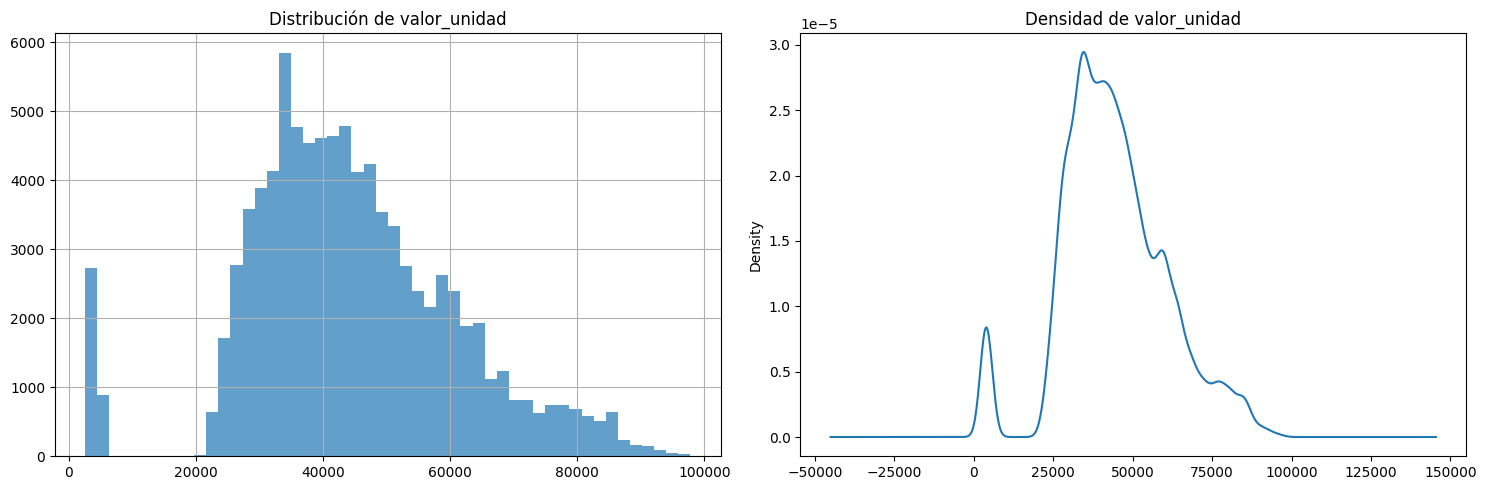

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df['valor_unidad'].hist(bins=50, alpha=0.7)
plt.title('Distribución de valor_unidad')
plt.subplot(1, 2, 2)
df['valor_unidad'].plot(kind='density')
plt.title('Densidad de valor_unidad')
plt.tight_layout()
plt.savefig('data/graficas_comparativas/distribucion_valor_unidad.png', dpi=300)
plt.savefig('data/graficas_comparativas/densidad_valor_unidad.png', dpi=300)
plt.show()
plt.close()


La densidad muestra una cola hacia la derecha y un pico central alrededor de los valores medios, evidencia de la tendencia creciente en el tiempo.

## 11. Evolución anual y autocorrelación
Revisamos estadísticas por año y la memoria temporal en un fondo representativo.

              mean           std      min       max
año                                                
2016  30933.310505   8090.679461  2596.40  44298.29
2017  34684.921141   9449.220153  2848.70  49635.24
2018  36858.466367  10147.320209  3135.23  51343.60
2019  39836.324999  11367.830222  3263.69  58638.94
2020  41744.940330  12139.707801  3326.61  63146.04


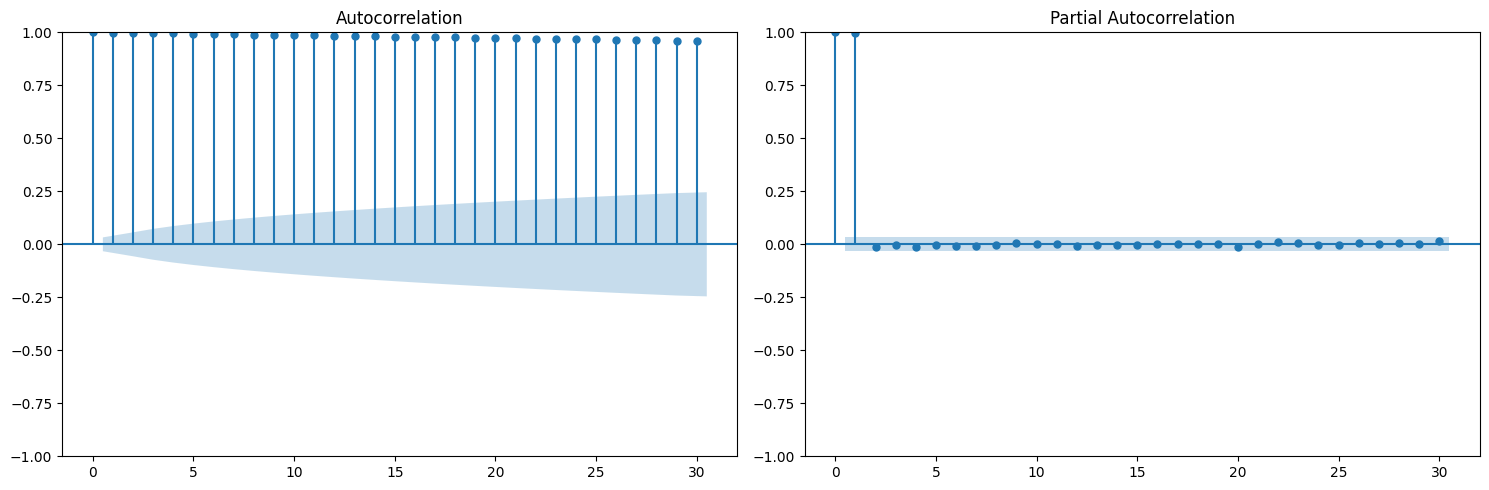

In [79]:
evolucion_anual = df.groupby('año')['valor_unidad'].agg(['mean', 'std', 'min', 'max'])
print(evolucion_anual.head())

if 'fecha' in skandia_moderado.columns:
    fondo_ejemplo = skandia_moderado.set_index('fecha')['valor_unidad']
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acf(fondo_ejemplo, lags=30, ax=plt.gca())
    plt.subplot(1, 2, 2)
    plot_pacf(fondo_ejemplo, lags=30, ax=plt.gca())
    plt.tight_layout()
    plt.savefig('data/graficas_comparativas/autocorrelacion.png', dpi=300)
    plt.show()
    plt.close()


Suele apreciarse una media anual creciente y autocorrelaciones altas en los primeros rezagos, típico en series financieras suavizadas.

## 12. Estacionalidad y boxplots por tipo de fondo
Exploramos estacionalidad mensual y la dispersión por categorías.

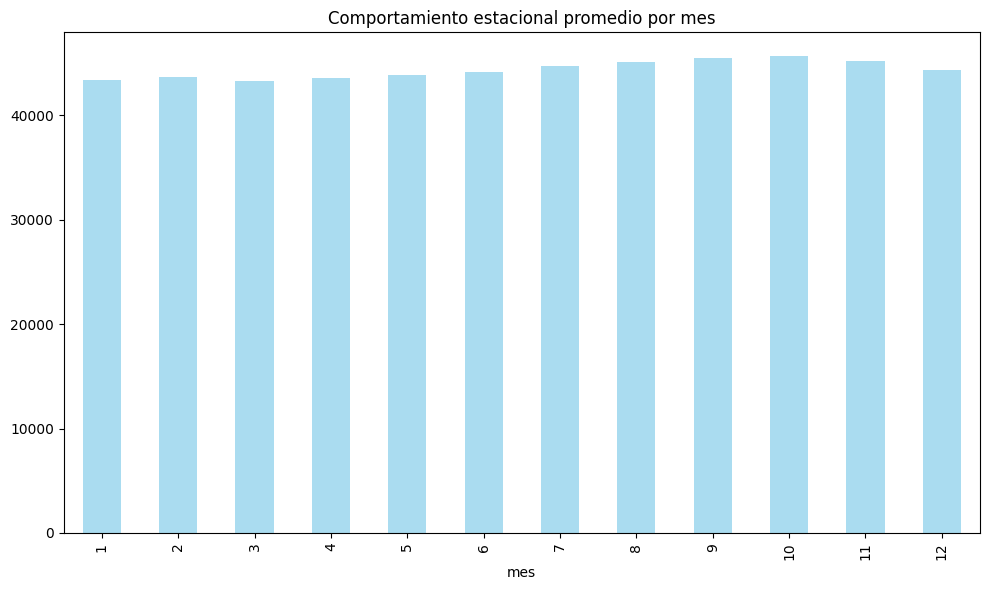

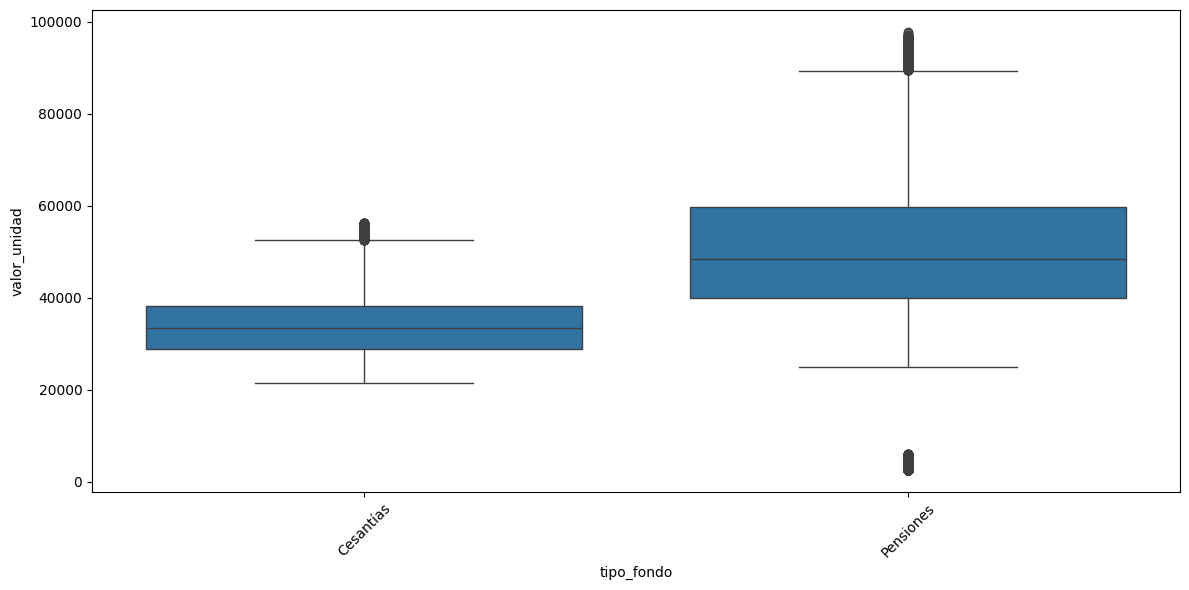

In [80]:
estacionalidad_mensual = df.groupby('mes')['valor_unidad'].mean()
plt.figure(figsize=(10, 6))
estacionalidad_mensual.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Comportamiento estacional promedio por mes')
plt.tight_layout()
plt.savefig('data/graficas_comparativas/estacionalidad_mensual.png', dpi=300)
plt.show()

plt.close()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='tipo_fondo', y='valor_unidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/graficas_comparativas/boxplot_tipos_fondo.png', dpi=300)
plt.show()

plt.close()


El promedio mensual tiende a escalar suavemente sin picos estacionales fuertes, mientras que los boxplots revelan que Pensiones Mayor Riesgo concentra los valores más volátiles.

## 13. Correlaciones y tendencias móviles
Construimos una matriz de correlación entre tipos y medias móviles de un fondo clave.

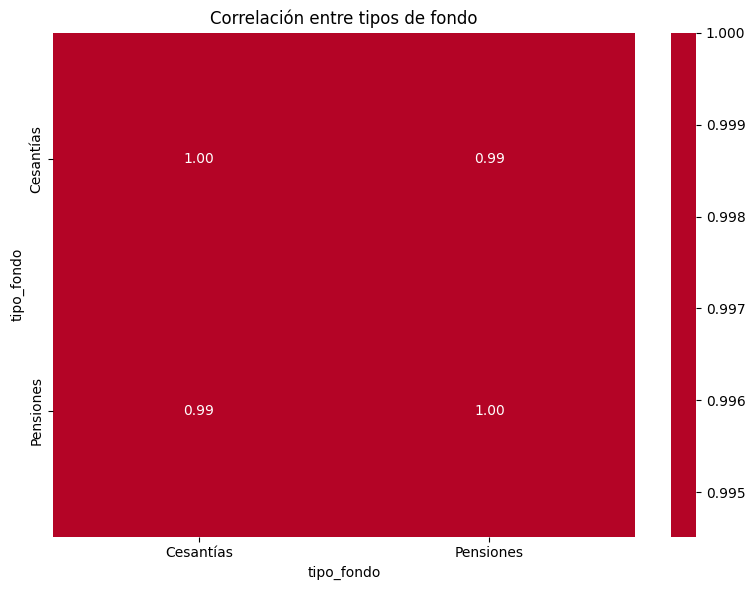

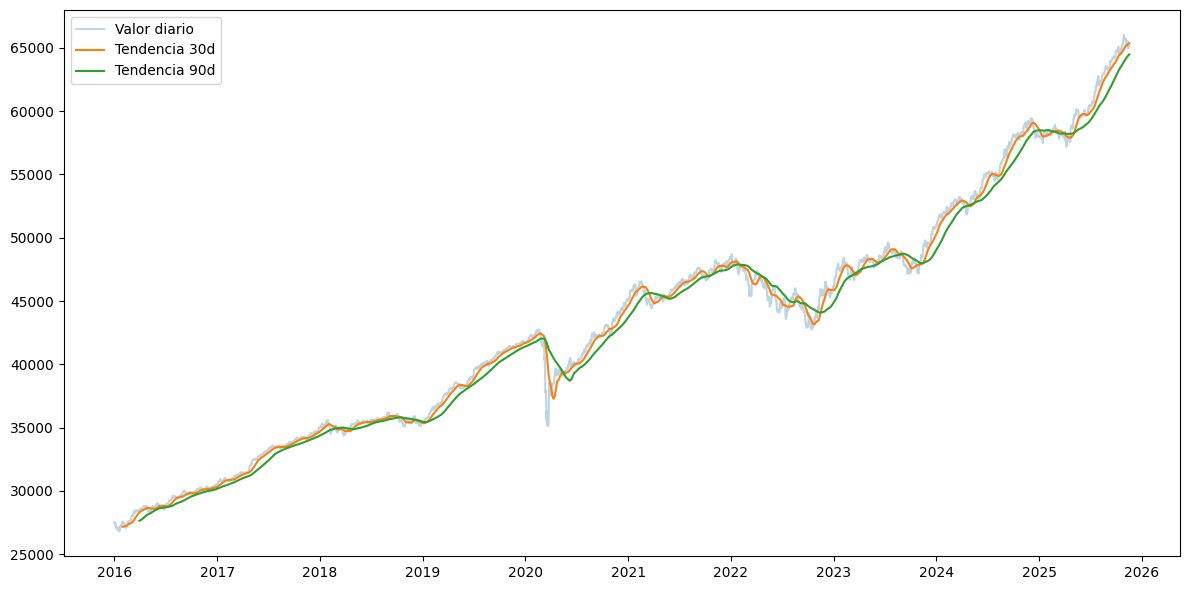

In [81]:
pivot_corr = df.pivot_table(index='fecha', columns='tipo_fondo', values='valor_unidad', observed=False).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlación entre tipos de fondo')
plt.tight_layout()
plt.savefig('data/graficas_comparativas/correlacion_tipos_fondo.png', dpi=300)
plt.show()

plt.close()

fondo_ejemplo = skandia_moderado.set_index('fecha')['valor_unidad']
tendencia_30d = fondo_ejemplo.rolling(window=30).mean()
tendencia_90d = fondo_ejemplo.rolling(window=90).mean()
plt.figure(figsize=(12, 6))
plt.plot(fondo_ejemplo.index, fondo_ejemplo.values, label='Valor diario', alpha=0.3)
plt.plot(tendencia_30d.index, tendencia_30d.values, label='Tendencia 30d')
plt.plot(tendencia_90d.index, tendencia_90d.values, label='Tendencia 90d')
plt.legend()
plt.tight_layout()
plt.savefig('data/graficas_comparativas/analisis_tendencia.png', dpi=300)
plt.show()

plt.close()


Las correlaciones entre tipos son altas (superiores a 0.8), lo que refleja que los fondos se mueven juntos; las medias móviles suavizan la tendencia alcista del fondo moderado.

## 14. Export para modelado y creación de lags
Generamos un dataset listo para modelar y nuevas columnas `lag` en distintos horizontes.

In [82]:
df_modelado = df.dropna(subset=['valor_unidad', 'fecha', 'nombre_entidad', 'nombre_fondo']).copy()
df_modelado.to_csv('data/processed/pensiones_listo_modelado.csv', index=False, encoding='utf-8')

lags = [1, 7, 30, 90, 180, 365]
lag_columns = {f'lag_{lag}': df['valor_unidad'].shift(lag) for lag in lags}
df = pd.concat([df, pd.DataFrame(lag_columns)], axis=1)
df.head()


,fecha,codigo_entidad,nombre_entidad,codigo_patrimonio,nombre_fondo,valor_unidad,es_outlier,año,mes,trimestre,tipo_fondo,lag_1,lag_7,lag_30,lag_90,lag_180,lag_365
0,2016-01-01,2,"""Proteccion""",1,Fondo de Cesantias Largo Plazo,23375.96,False,2016,1,1,Cesantías,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-01,2,"""Proteccion""",2,Fondo de Cesantias Corto Plazo,23322.60,False,2016,1,1,Cesantías,23375.96,NaN,NaN,NaN,NaN,NaN
2,2016-01-01,2,"""Proteccion""",1000,Fondo de Pensiones Moderado,37972.06,False,2016,1,1,Pensiones,23322.60,NaN,NaN,NaN,NaN,NaN
3,2016-01-01,2,"""Proteccion""",5000,Fondo de Pensiones Conservador,39207.35,False,2016,1,1,Pensiones,37972.06,NaN,NaN,NaN,NaN,NaN
4,2016-01-01,2,"""Proteccion""",6000,Fondo de Pensiones Mayor Riesgo,38410.19,False,2016,1,1,Pensiones,39207.35,NaN,NaN,NaN,NaN,NaN


Con esto quedan disponibles los CSV `pensiones_listo_modelado.csv` y múltiples `lag_n` que alimentan los modelos ARIMA/SARIMA del script original.

## 15. Siguientes etapas
A partir de este punto el notebook puede continuar con los bloques de modelado (ARIMA, SARIMA, regresiones e IPC) replicando exactamente las secciones finales de `pensiones.py`.